# jiu-jitsu-auto-scoring
*This notebook is a **WIP**!*


In [1]:
# prompt: mount drive and clone the repository in the current branch, the organization is called jiu-jitsu-auto-scoring and the repository is called model
from google.colab import drive

BRANCH = "5-try-out-vitpose" # Write the name of the branch you're working in here

!git clone -q https://github.com/jiu-jitsu-auto-scoring/model.git
%cd /content/model
!git pull
!git checkout $BRANCH

fatal: destination path 'model' already exists and is not an empty directory.
/content/model
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 3.54 KiB | 1.77 MiB/s, done.
From https://github.com/jiu-jitsu-auto-scoring/model
   62b5c38..b1b0f4a  5-try-out-vitpose -> origin/5-try-out-vitpose
Updating 62b5c38..b1b0f4a
Fast-forward
 src/ViTPose_Image_Demo.ipynb | 587 ++++++++++++++++++++++++---------------------------------------
 1 file changed, 225 insertions(+), 362 deletions(-)
Already on '5-try-out-vitpose'
Your branch is up to date with 'origin/5-try-out-vitpose'.


In [2]:
!git clone https://github.com/ViTAE-Transformer/ViTPose.git
%cd ViTPose

!pip install -r requirements.txt
!pip install -e .

!pip install supervision # for visualizing keypoints


fatal: destination path 'ViTPose' already exists and is not an empty directory.
/content/model/ViTPose
Ignoring dataclasses: markers 'python_version == "3.6"' don't match your environment
  Cloning https://github.com/svenkreiss/poseval.git to /tmp/pip-install-caj62r1d/poseval_7fdf4f1e2a1c42ae9cf8da5d996ec45b
  Running command git clone --filter=blob:none --quiet https://github.com/svenkreiss/poseval.git /tmp/pip-install-caj62r1d/poseval_7fdf4f1e2a1c42ae9cf8da5d996ec45b
  Resolved https://github.com/svenkreiss/poseval.git to commit 3128c5cbcf90946e5164ff438ad651e113e64613
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
Obtaining file:///content/model/ViTPose
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmpose
    Found existing installation: mmpose 0.24.0
    Uninstalling mmpose-0.24.0:
      Successfully uninstalled mmpose-0.24.0
  Running setup.py develop for mmpose
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

Create a folder Model/VitPose/Checkpoints. Upload the required checkpoint into that folder

In [3]:
!mkdir -p checkpoints

In [4]:
import torch
import requests
import numpy as np

from PIL import Image

from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [6]:
url = "http://images.cocodataset.org/val2017/000000000139.jpg"
image = Image.open(requests.get(url, stream=True).raw)

Stage 1. Detect humans on the image


In [7]:
# You can choose any detector of your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Stage 2. Detect keypoints for each person found

In [8]:
image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]  # results for first image

In [9]:


import supervision as sv

xy = torch.stack([pose_result['keypoints'] for pose_result in image_pose_result]).cpu().numpy()
scores = torch.stack([pose_result['scores'] for pose_result in image_pose_result]).cpu().numpy()

key_points = sv.KeyPoints(
    xy=xy, confidence=scores
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.GREEN,
    thickness=1
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.RED,
    radius=2
)
annotated_frame = edge_annotator.annotate(
    scene=image.copy(),
    key_points=key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points
)

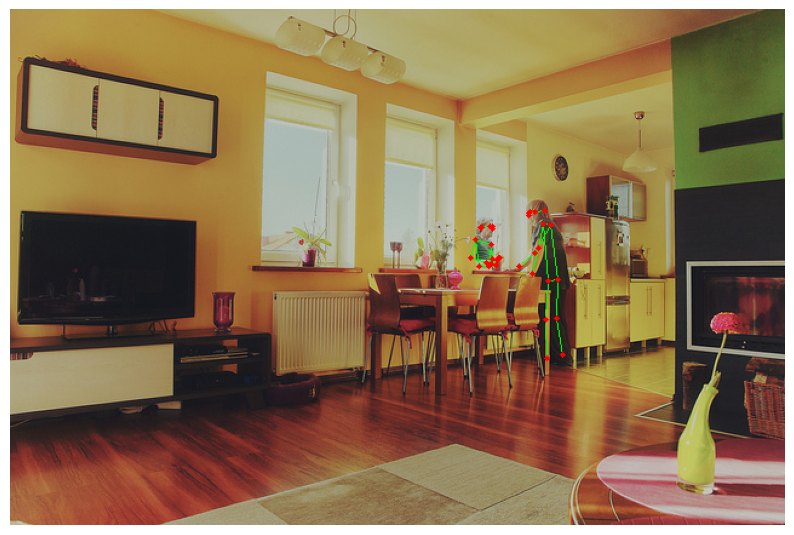

In [12]:
# prompt: Display the resultant image

from google.colab import drive
import torch
import requests
import numpy as np
from PIL import Image
from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation
import supervision as sv
import matplotlib.pyplot as plt

# ... (rest of your code) ...

# Display the annotated image
plt.figure(figsize=(10, 10))
plt.imshow(annotated_frame)
plt.axis('off')
plt.show()
